<a href="https://colab.research.google.com/github/Mrfrktmrck19/Data_Science/blob/master/Data%20Augmentation/DataAugWithKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


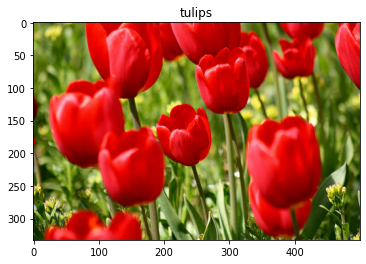

In [4]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [5]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

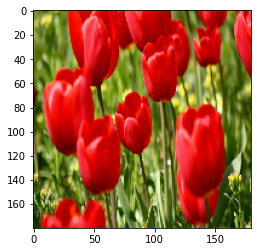

In [6]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [7]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())


Min and max pixel values: 0.0 1.0


In [8]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [9]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

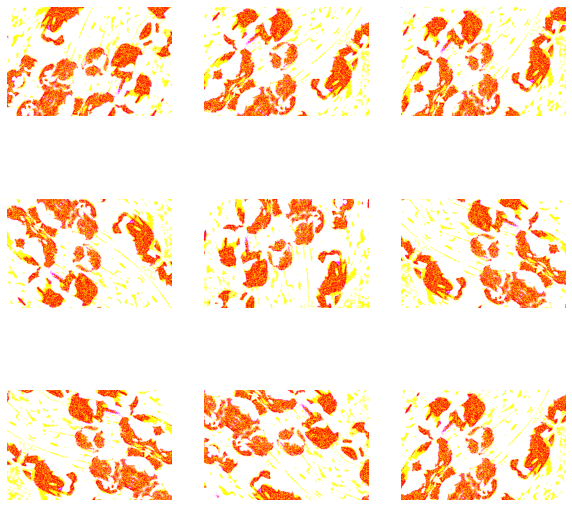

In [10]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [11]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

In [12]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

In [13]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [15]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 105s 1s/step - loss: 1.2854 - accuracy: 0.4452 - val_loss: 1.1232 - val_accuracy: 0.5804
Epoch 2/5
92/92 [==============================] - 90s 963ms/step - loss: 1.0688 - accuracy: 0.5623 - val_loss: 1.0145 - val_accuracy: 0.6267
Epoch 3/5
92/92 [==============================] - 89s 960ms/step - loss: 0.9831 - accuracy: 0.6076 - val_loss: 1.0485 - val_accuracy: 0.5967
Epoch 4/5
92/92 [==============================] - 89s 955ms/step - loss: 0.9128 - accuracy: 0.6448 - val_loss: 0.9264 - val_accuracy: 0.6567
Epoch 5/5
92/92 [==============================] - 89s 957ms/step - loss: 0.8854 - accuracy: 0.6499 - val_loss: 0.9165 - val_accuracy: 0.6322


In [19]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 5s 352ms/step - loss: 0.8728 - accuracy: 0.6131
Accuracy 0.6130790114402771


In [20]:
##  Custom Data Augmentation